# Setting Environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import ast
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import  Dense, SimpleRNN, Embedding, Input, Activation, Dropout, LSTM
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import RMSprop
from keras.callbacks import Callback, EarlyStopping

In [2]:
df = pd.read_csv('./combined_tweets.csv')
X = df.tweet
y = df.sentimen
X.shape, y.shape

((3627,), (3627,))

In [3]:
# buat label encoder
labelencoder = LabelEncoder()

y = labelencoder.fit_transform(df.sentimen)
print('Encoded labels:', y)
print('Original labels:', labelencoder.inverse_transform(y))

Encoded labels: [2 0 0 ... 1 2 0]
Original labels: ['positif' 'negatif' 'negatif' ... 'netral' 'positif' 'negatif']


# Data Modeling

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, to_categorical(y,3), test_size=0.20, random_state=42)

In [5]:
max_words = 1000
max_len = 3000
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
X_train_sequences = tok.texts_to_sequences(X_train)
X_train_sequences_matrix = pad_sequences(X_train_sequences,maxlen=max_len)

X_test_sequences = tok.texts_to_sequences(X_test)
X_test_sequences_matrix = pad_sequences(X_test_sequences,maxlen=max_len)


In [6]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2901,), (726,), (2901, 3), (726, 3))

In [7]:
X_train_sequences_matrix.shape, X_test_sequences_matrix.shape, y_train.shape, y_test.shape

((2901, 3000), (726, 3000), (2901, 3), (726, 3))

# Model Training with:

In [8]:
# define RNN
def SNN():
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(max_words, 5, input_length=max_len)(inputs)
    layer = LSTM(8)(layer)
    layer = Dense(4, name='FC1')(layer)
    layer = Dropout(0.2)(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(3, name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

In [9]:
model = SNN()
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 3000)]            0         
                                                                 
 embedding (Embedding)       (None, 3000, 5)           5000      
                                                                 
 lstm (LSTM)                 (None, 8)                 448       
                                                                 
 FC1 (Dense)                 (None, 4)                 36        
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 activation (Activation)     (None, 4)                 0         
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0     

In [10]:
model.fit(X_train_sequences_matrix, 
          y_train,
          batch_size=32,
          epochs=25,
          #validation_data=(X_test_sequences_matrix, y_test),
          validation_split=0.2,
        #   callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)]
          )

Epoch 1/25
73/73 [==============================] - 143s 2s/step - loss: 1.0986 - accuracy: 0.3310 - val_loss: 1.0968 - val_accuracy: 0.3408
Epoch 2/25
73/73 [==============================] - 166s 2s/step - loss: 1.0924 - accuracy: 0.3767 - val_loss: 1.0859 - val_accuracy: 0.4475
Epoch 3/25
73/73 [==============================] - 181s 2s/step - loss: 1.0792 - accuracy: 0.4082 - val_loss: 1.0678 - val_accuracy: 0.4682
Epoch 4/25
73/73 [==============================] - 159s 2s/step - loss: 1.0613 - accuracy: 0.4190 - val_loss: 1.0466 - val_accuracy: 0.4991
Epoch 5/25
73/73 [==============================] - 90s 1s/step - loss: 1.0420 - accuracy: 0.4418 - val_loss: 1.0339 - val_accuracy: 0.4940
Epoch 6/25
73/73 [==============================] - 79s 1s/step - loss: 1.0203 - accuracy: 0.4737 - val_loss: 1.0110 - val_accuracy: 0.5112
Epoch 7/25
73/73 [==============================] - 83s 1s/step - loss: 0.9940 - accuracy: 0.5030 - val_loss: 0.9759 - val_accuracy: 0.5353
Epoch 8/25
73/73

# Model Evaluation

In [11]:
baseline_test_acc = np.mean(np.dot(y_test, np.arange(3)) == 2)
baseline_test_acc

0.34573002754820936

In [12]:
accr = model.evaluate(X_test_sequences_matrix, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

23/23 [==============================] - 4s 178ms/step - loss: 0.9957 - accuracy: 0.5592
Test set
  Loss: 0.996
  Accuracy: 0.559


In [13]:
# mengembalikan to_categorical y_test menjadi list
y_test = np.argmax(y_test,axis=1)
y_test

array([2, 1, 1, 0, 1, 2, 2, 1, 2, 2, 1, 2, 1, 0, 0, 2, 2, 1, 2, 2, 0, 1,
       2, 2, 0, 0, 2, 0, 1, 0, 2, 0, 1, 2, 0, 2, 2, 0, 2, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 2, 0, 1, 2, 1, 2, 2, 0, 1, 2, 2, 1, 0, 0, 2, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 0, 0, 0, 2, 0,
       0, 1, 0, 0, 1, 1, 2, 1, 1, 2, 0, 2, 1, 1, 2, 2, 2, 1, 0, 0, 0, 0,
       1, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 1, 1, 1, 0, 0, 2, 1, 0, 1, 0, 1,
       2, 0, 0, 2, 1, 0, 1, 1, 1, 2, 1, 1, 2, 0, 2, 2, 2, 2, 2, 1, 0, 0,
       2, 0, 0, 0, 2, 0, 1, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 0, 1, 0, 1, 2,
       1, 1, 1, 1, 0, 2, 1, 2, 2, 1, 0, 2, 1, 0, 2, 2, 2, 2, 2, 1, 0, 0,
       2, 2, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 2, 0, 1, 0, 1, 2, 1, 0, 0,
       1, 2, 0, 0, 2, 1, 2, 0, 2, 1, 2, 1, 2, 1, 2, 0, 1, 0, 0, 1, 2, 2,
       1, 1, 2, 1, 1, 1, 1, 2, 2, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 2, 1, 1,
       1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 1, 0, 2, 1, 2, 1, 0,
       2, 1, 0, 0, 2, 0, 0, 2, 2, 2, 1, 1, 2, 1, 0,

In [14]:
# predict y_pred untuk Confusion Matrix
y_pred = model.predict(X_test_sequences_matrix)
y_pred_class = np.argmax(y_pred, axis=1)
y_pred_class

23/23 [==============================] - 5s 190ms/step


array([1, 1, 2, 1, 1, 2, 1, 0, 2, 0, 1, 2, 1, 1, 0, 2, 1, 0, 0, 0, 2, 1,
       0, 2, 0, 0, 2, 1, 1, 1, 2, 0, 0, 2, 0, 2, 0, 2, 2, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 2, 0, 2, 2, 0, 1, 0, 0, 2, 1, 1, 2, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 2, 2, 0, 0, 0, 2, 1, 0, 1, 1, 2, 2,
       1, 1, 2, 2, 2, 2, 2, 0, 1, 2, 0, 0, 1, 0, 1, 2, 0, 1, 0, 1, 0, 1,
       1, 2, 2, 1, 2, 1, 0, 0, 1, 2, 1, 1, 0, 1, 0, 0, 2, 1, 0, 1, 0, 1,
       2, 2, 2, 2, 1, 2, 0, 1, 0, 2, 1, 1, 2, 0, 1, 2, 2, 0, 2, 1, 1, 0,
       2, 0, 1, 1, 2, 0, 1, 0, 2, 1, 1, 1, 2, 1, 2, 1, 0, 0, 0, 0, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 2, 0, 0, 2, 0, 2, 2, 1, 1, 0, 2,
       2, 2, 1, 0, 0, 0, 2, 1, 0, 2, 0, 1, 1, 1, 1, 0, 2, 1, 0, 1, 0, 2,
       1, 2, 2, 2, 1, 1, 2, 1, 0, 2, 2, 1, 2, 0, 2, 2, 1, 0, 0, 1, 0, 1,
       0, 2, 0, 1, 0, 1, 1, 1, 2, 1, 0, 0, 1, 0, 0, 0, 2, 0, 0, 2, 1, 2,
       0, 0, 0, 2, 0, 1, 0, 2, 2, 2, 2, 1, 0, 0, 2, 1, 2, 2, 2, 2, 1, 1,
       2, 1, 0, 0, 1, 2, 1, 0, 2, 2, 1, 2, 0, 1, 1,

In [15]:
# Assuming y_true and y_pred are your data
cm = confusion_matrix(y_test, np.rint(y_pred_class))
cm

array([[108,  81,  30],
       [ 68, 157,  31],
       [ 64,  46, 141]], dtype=int64)

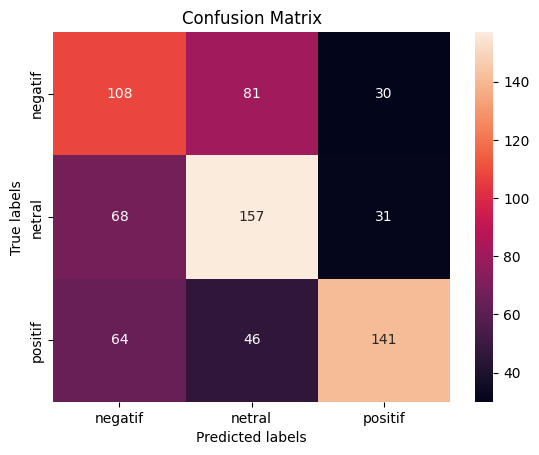

In [16]:
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['negatif','netral', 'positif'])  # replace with your classes
ax.yaxis.set_ticklabels(['negatif','netral', 'positif'])  # replace with your classes

plt.show()

In [17]:
report = classification_report(y_test, np.rint(y_pred_class))
print(report)

              precision    recall  f1-score   support

           0       0.45      0.49      0.47       219
           1       0.55      0.61      0.58       256
           2       0.70      0.56      0.62       251

    accuracy                           0.56       726
   macro avg       0.57      0.56      0.56       726
weighted avg       0.57      0.56      0.56       726

